# Reading a cluster file

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

Example run on: **2025-04-14 13:11** with aare: **dev**

## Read all clusters and fill a histogram

Reading clusters and filling histogram tool 0.026s


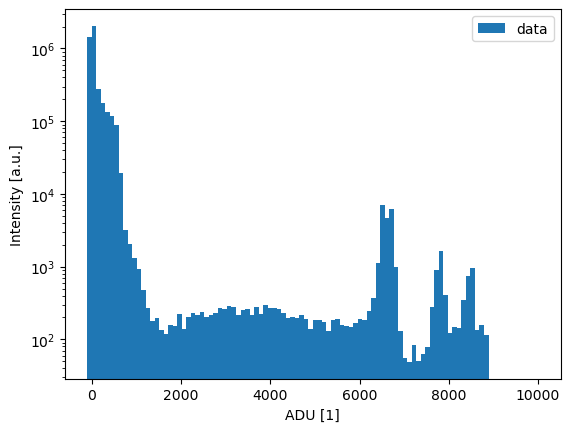

In [2]:
# from aare import ClusterFile
from aare import ClusterFile
import boost_histogram as bh


base = Path('/mnt/sls_det_storage/matterhorn_data/aare_test_data/ci/aare_test_data/clusters/')
fname = 'beam_En700eV_-40deg_300V_10us_d0_f0_100.clust'


# Create the histogram
n_bins = 100
xmin = -100
xmax = 1e4
hist_aare = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))

t0 = time.perf_counter()
#Read clusters and fill the histogram with pixel values
with ClusterFile(base/fname, chunk_size = 10000) as f:
    for clusters in f:
        arr = np.array(clusters, copy = False)
        hist_aare.fill(arr['data'].flat)

t = time.perf_counter()-t0
print(f'Reading clusters and filling histogram tool {t:.3f}s')

#Plotting
fig, ax = plt.subplots()
ax.bar(hist_aare.axes[0].centers, hist_aare.values(), width=hist_aare.axes[0].widths, label = 'data')
ax.set_yscale('log')
ax.set_xlabel('ADU [1]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend();

## Sanity check using pure python

Reading 1000 frames with python took: 13.423s


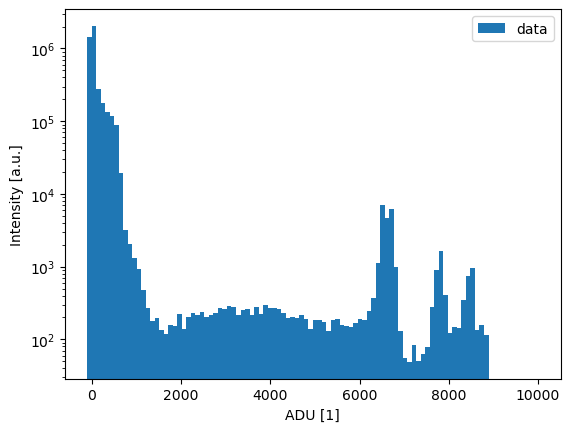

In [3]:
hist_py = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))

t0 = time.perf_counter()
N = 1500 #Maximum frames
with open(base/fname, 'rb') as f:
    for i in range(N):
        frame_number = np.fromfile(f, count=1, dtype = np.int32)
        if frame_number.size == 0:
            break
        n_clusters = np.fromfile(f, count=1, dtype = np.uint32)[0]
        for i in range(n_clusters):
            xy = np.fromfile(f, count=2, dtype = np.uint16)
            data = np.fromfile(f, count=9, dtype = np.int32)
            hist_py.fill(data)
t = time.perf_counter()-t0
print(f'Reading {i} frames with python took: {t:.3f}s')

#Plotting
fig, ax = plt.subplots()
ax.bar(hist_py.axes[0].centers, hist_py.values(), width=hist_py.axes[0].widths, label = 'data')
ax.set_yscale('log')
ax.set_xlabel('ADU [1]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()

In [4]:
assert hist_aare==hist_py

## Read some clusters

In [ ]:
from aare import hitmap, ROI


roi = ROI(xmin = 100, xmax = 300, ymin= 50, ymax = 399)

# Create the histogram
n_bins = 100
xmin = -100
xmax = 1e4
hist_aare = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))

image = np.zeros((400, 400))

t0 = time.perf_counter()
#Read clusters and fill the histogram with pixel values
with ClusterFile(base/fname, chunk_size = 10000) as f:
    f.set_roi(roi)
    for clusters in f:
        arr = np.array(clusters, copy = False)
        hist_aare.fill(arr['data'].flat)
        image += hitmap((400,400), clusters)

t = time.perf_counter()-t0
print(f'Reading clusters and filling histogram tool {t:.3f}s')

#Plotting
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].bar(hist_aare.axes[0].centers, hist_aare.values(), width=hist_aare.axes[0].widths, label = 'data')
axs[0].set_yscale('log')
axs[0].set_xlabel('ADU [1]')
axs[0].set_ylabel('Intensity [a.u.]')
axs[0].legend();

im = axs[1].imshow(image)
im.set_clim(0,30)